<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit8/NeevSabhUnit8Proj_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
!pip install pymc-bart
import pymc_bart as pmb

#**Unit 8 Project: Predicting Credit Score**

For this project, I wanted to expand more on what I did for the last project, so using the same data set and idea, I wanted to do a slight spin on it and try to predict credit scores for fun.

##**Data**

Same data from my last project, but just to refresh memory, it is a data set that I got from kaggle (tried to find a similar data set that was good and not on kaggle, however I did not find one)

In [2]:
loancsv = 'https://raw.githubusercontent.com/NeevSabhani/Data-Science/refs/heads/main/Unit7/loan_data.csv'
loan = pd.read_csv(loancsv)
loan = loan.head(2000)
# Remove rows where person_income is greater than 500,000
loan = loan[loan['person_income'] <= 500000].reset_index(drop=True)
loan

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,21.0,male,Associate,36953.0,0,MORTGAGE,6400.0,VENTURE,11.01,0.17,3.0,567,Yes,0
1995,21.0,male,Master,37264.0,0,RENT,14000.0,MEDICAL,10.65,0.38,2.0,545,No,1
1996,24.0,female,Associate,36841.0,4,RENT,14000.0,DEBTCONSOLIDATION,7.90,0.38,2.0,538,No,1
1997,24.0,male,Bachelor,37068.0,2,MORTGAGE,3075.0,DEBTCONSOLIDATION,11.01,0.08,4.0,521,Yes,0


##**Casual Diagram**

###**Code**

In [3]:
import graphviz

dot = graphviz.Digraph(format='png')

# Nodes
dot.node("Age", "Person Age")
dot.node("Education", "Education Level")
dot.node("Income", "Applicant Income")
dot.node("LoanIntent", "Loan Intent")
dot.node("LoanAmt", "Loan Amount")
dot.node("LoanIntRate", "Loan Interest Rate")
dot.node("LoanPctIncome", "Loan % of Income")
dot.node("CreditScore", "Credit Score")
dot.node("InterestRates", "Interest Rates")
dot.node("Inflation", "Inflation Rate")
dot.node("EconomicConditions", "Economic Conditions")
dot.node("BankPolicies", "Bank Lending Policies")
dot.node("MarketTrends", "Housing & Market Trends")

# Primary predictors to CreditScore
dot.edge("Age", "CreditScore")
dot.edge("Income", "CreditScore")
dot.edge("LoanAmt", "CreditScore")

# Show interaction edges
dot.edge("Age", "Income")
dot.edge("Age", "LoanAmt")
dot.edge("Income", "LoanAmt")  # income often determines borrowing capacity

# Other supporting causal factors
dot.edge("Education", "Income")
dot.edge("LoanIntent", "LoanAmt")
dot.edge("LoanIntRate", "LoanAmt")
dot.edge("LoanPctIncome", "LoanAmt")

dot.edge("InterestRates", "LoanIntRate")
dot.edge("Inflation", "LoanIntRate")
dot.edge("BankPolicies", "LoanIntRate")
dot.edge("MarketTrends", "LoanAmt")
dot.edge("EconomicConditions", "Income")

###**Image**

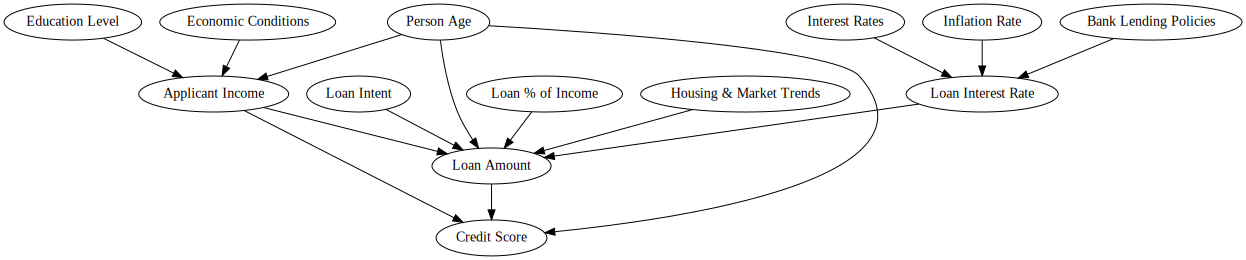

In [4]:
dot

For my BART model, I chose to use only **Loan Amount**, **Person Age**, and **Applicant Income** to predict Credit Score. Looking at my causal diagram, it’s clear that many factors can influence credit score, but I focused on these three because they have strong, direct connections to credit score and also influence one another in meaningful ways. For example, a person’s age often affects their income level, and together, age and income can shape the size of the loan someone applies for. These relationships form a kind of foundation for understanding someone’s creditworthiness. Other variables, like Loan % of Income or Interest Rate, are based on or influenced by these core features, so including them felt redundant. I also left out broader economic factors like Inflation or Bank Policies, since they aren't specific to individual borrowers and weren't available in my dataset. Overall, I believe that Loan Amount, Age, and Income offer the clearest insight into someone’s credit score, which is why they are the focus of my model.

(If you remember from my last project, this is similar to what I said there too, not much of a change from that)

##**Model Making**

In [5]:
X = loan[["person_income", "person_age", "loan_amnt"]]
Y = loan["credit_score"].to_numpy()

###**1**

In [ ]:
with pm.Model() as model_1:
    s = pm.HalfNormal('s', sigma=50)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y)
    idata_1 = pm.sample(compute_convergence_checks=False)

In [ ]:
pm.sample_posterior_predictive(idata_1,model_1, extend_inferencedata=True)

(400.0, 800.0)

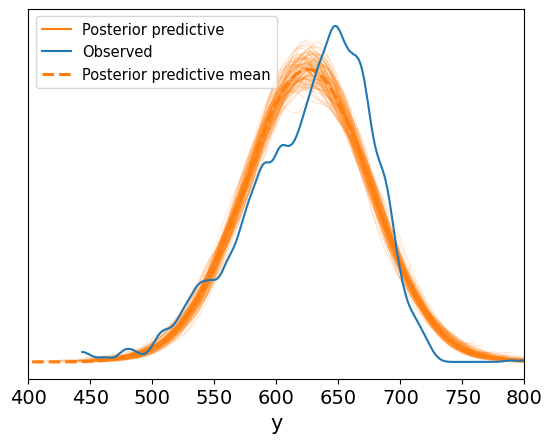

In [8]:
ax = az.plot_ppc(idata_1, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(400, 800)

###**2**

In [ ]:
with pm.Model() as model_2:
    s = pm.HalfNormal('s', sigma=50)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.SkewNormal("y", mu=μ, sigma=s, alpha=-3, observed=Y)
    idata_2 = pm.sample(compute_convergence_checks=False)

In [ ]:
pm.sample_posterior_predictive(idata_2,model_2, extend_inferencedata=True)


(400.0, 800.0)

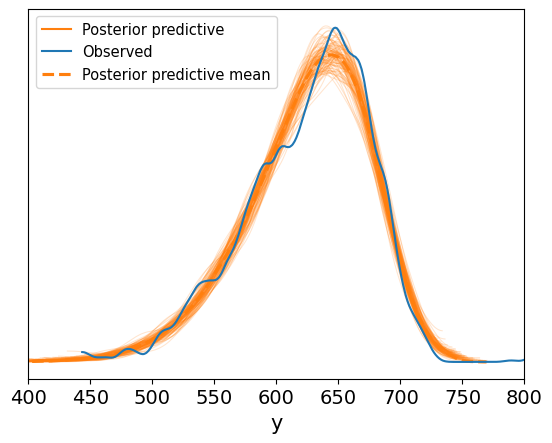

In [11]:
ax = az.plot_ppc(idata_2, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(400, 800)

###**3**

In [ ]:
with pm.Model() as model_3:
    s = pm.HalfNormal('s', sigma=10)
    μ_ = pmb.BART("μ_", X, Y, m=100)
    μ = pm.Deterministic("μ", μ_)
    y = pm.SkewStudentT("y", mu=μ, sigma=s, a=1, b=1, observed=Y)
    idata_3 = pm.sample(compute_convergence_checks=False)


In [ ]:
pm.sample_posterior_predictive(idata_3,model_3, extend_inferencedata=True)


(400.0, 800.0)

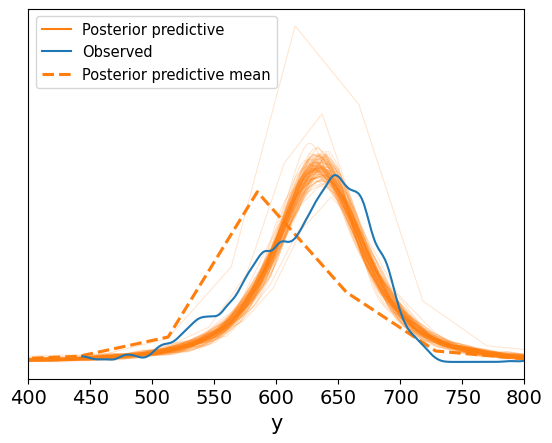

In [14]:
ax = az.plot_ppc(idata_3, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(400, 800)

Out of all three models, I believe the **SkewNormal model (Model 2)** performs the best. When examining the posterior predictive check (PPC), the alignment between the observed data and the model’s predictions is stronger than in the other models. The peaks of the observed and posterior distributions are closely aligned, and the shape of the predictive curve captures a slight asymmetry that looks more realistic than a perfectly symmetric fit. The height of the peak also matches well — the posterior mean sits just slightly under the observed values. Overall, this model offers the best combination of accuracy and visual consistency.

##**Analysis**

###**Posterior Predictive Plot**

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


[Text(0.5, 1.0, 'Posterior Predictive of Loan Amounts'),
 Text(0.5, 0, 'Applicant Income'),
 Text(0, 0.5, 'Credit score')]

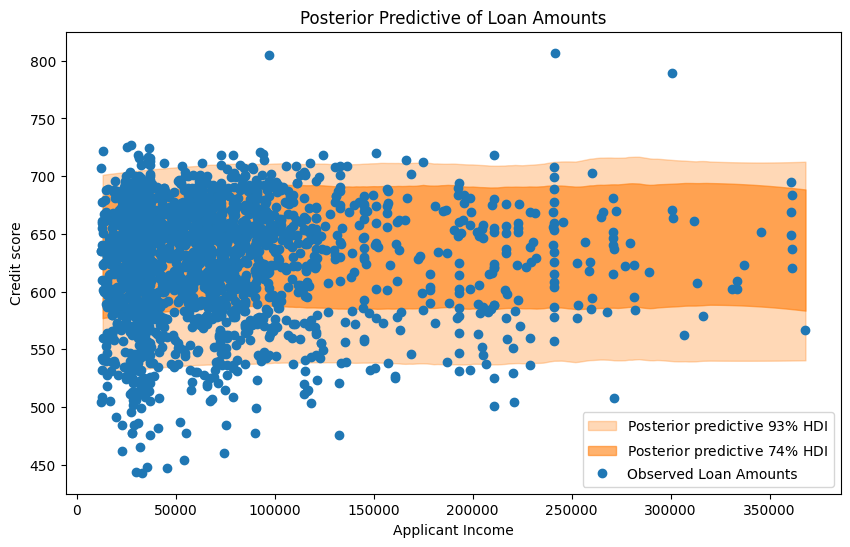

In [15]:
posterior_mean = idata_2.posterior["μ"]

# Compute 74% HDI for μ
μ_hdi = az.hdi(ary=idata_2, group="posterior", var_names=["μ"], hdi_prob=0.74)

# Extract posterior predictive samples for y
pps = az.extract(idata_2, group="posterior_predictive", var_names=["y"]).T  # shape: (samples, observations)

# Sort by first feature: person_income
x_axis = X["person_income"].values
idx = np.argsort(x_axis)
x_sorted = x_axis[idx]
pps_sorted = pps[:, idx]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# 93% HDI band
az.plot_hdi(
    x=x_sorted,
    y=pps_sorted,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

# 74% HDI band
az.plot_hdi(
    x=x_sorted,
    y=pps_sorted,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Posterior predictive $74\%$ HDI"},
)

# Plot observed loan amounts
ax.plot(x_sorted, Y[idx], "o", c="C0", label="Observed Loan Amounts")

# Final labels and legend
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive of Loan Amounts",
    xlabel="Applicant Income",
    ylabel="Credit score",
)



This plot suggests that **income doesn't have a strong relationship with credit score** in this dataset. The model’s predictions (shown by the HDI bands) remain relatively flat across the full range of income, and the observed data points are scattered throughout without a clear upward or downward trend. This means that, according to the model, someone earning 30,000 could have a similar credit score to someone earning 300,000.

However, it's also worth noting that there are **a lot of data points**, especially clustered in the lower income range. This high density of observations may make it harder for the model to detect subtle patterns or relationships. The noise and variability in the data could be affecting the model’s ability to learn a clear trend.

In reality, this result still makes some sense — income alone doesn’t determine credit score. A person’s score depends much more on how they manage their credit than on how much they earn. So while we might expect some correlation, this plot shows that the connection is weak and easily lost in the data’s variability.

###**PairPlot**

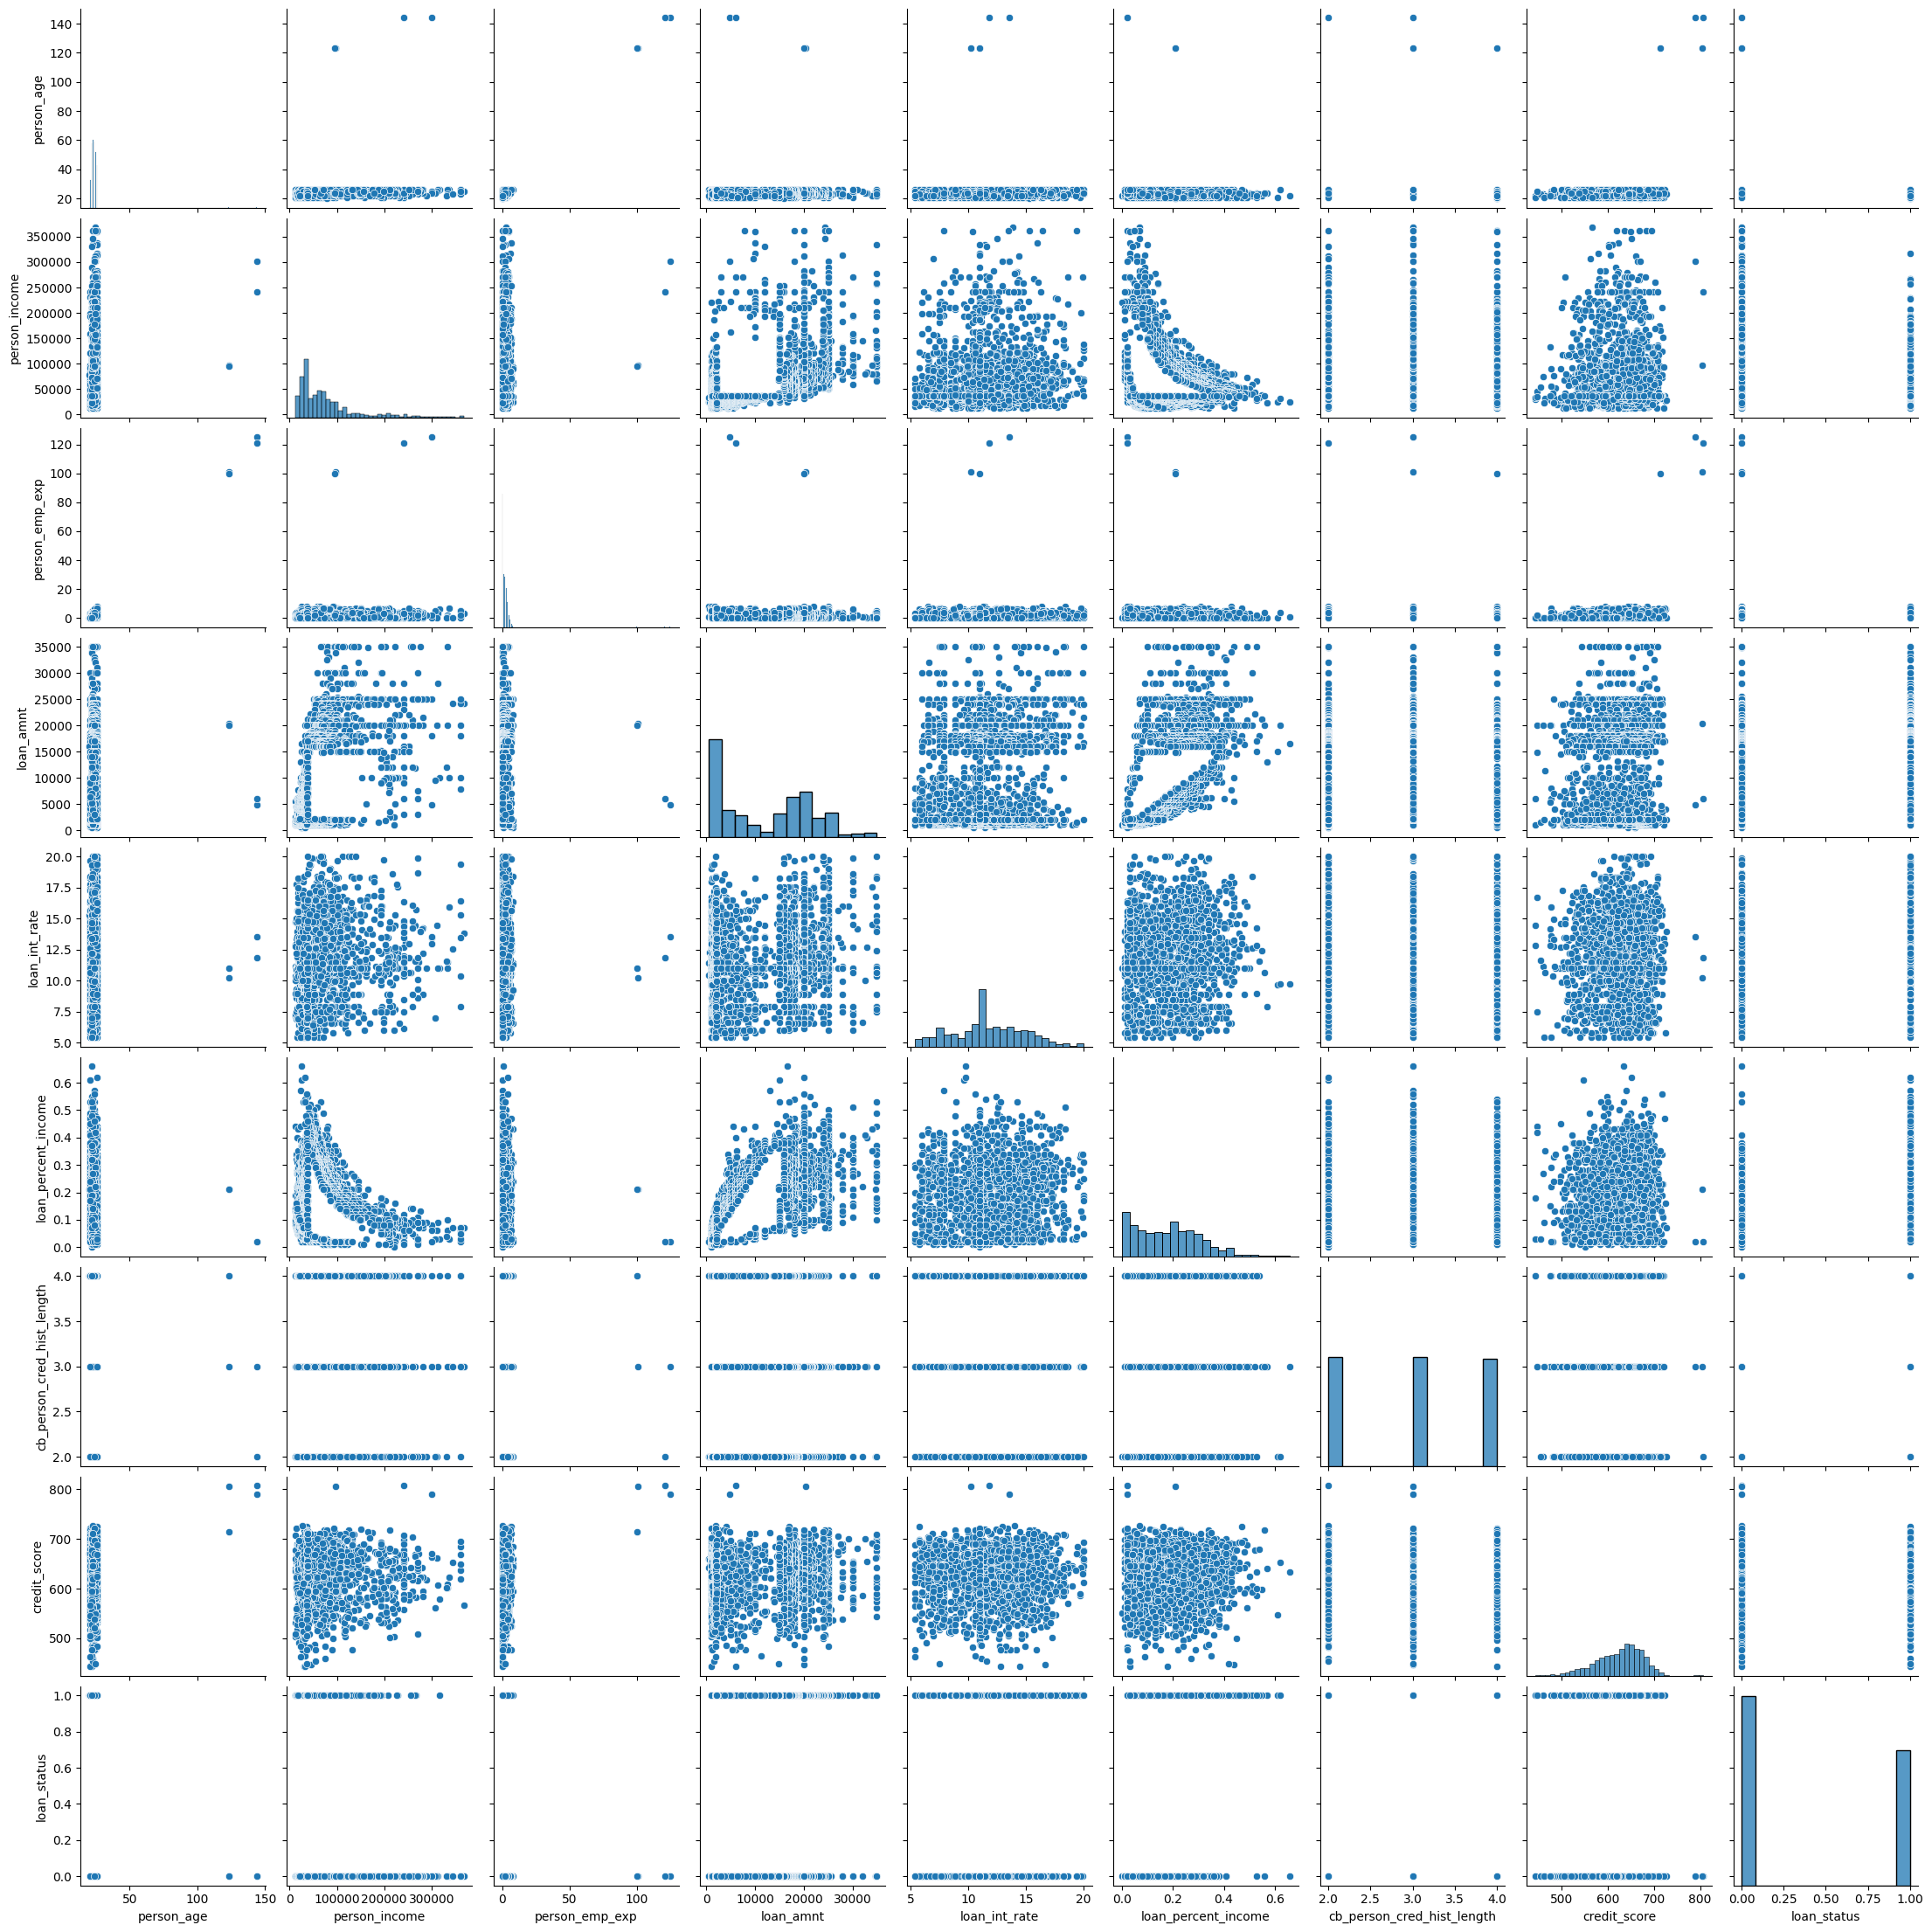

In [16]:
sns.pairplot(loan)

This pairplot shows that while some relationships exist in the dataset — like income correlating with loan amount, and credit score influencing interest rate — many of the variables have weak or noisy relationships. So this dataset probably isnt the greatest, but its what we will work with and we will try our best to extract as much information as possible from the following graphs.

###**VI**

<Axes: ylabel='R²'>

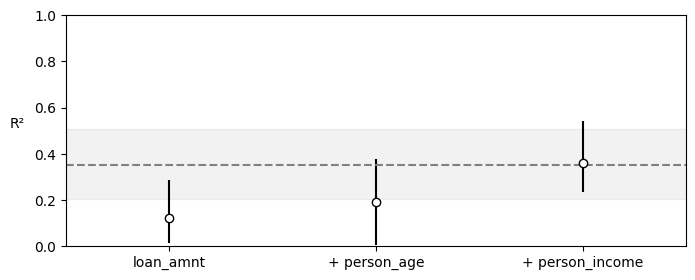

In [17]:
vi_ff = pmb.compute_variable_importance(idata_2, μ_, X)
pmb.plot_variable_importance(vi_ff)



Looking at the Variable Importance graph, it's clear that **person income** is the only variable that meaningfully contributes to the model. It adds about **0.2 to the R² score**, while **person age** and **loan amount** contribute almost nothing. This is different from what I found in my previous project, where income was also important, but the other variables had at least some effect.  

I expected **loan amount** to have a stronger relationship with credit score, especially since people with higher credit scores typically qualify for larger loans. I also thought **age** might have some influence as well. But in this case, the model suggests that income is really the only useful variable when predicting credit score, and the others don’t help much at all. This outcome is a bit surprising, but it shows how credit score may be influenced by other factors not included in the model — like credit history, payment behavior, or debt-to-income ratio.

###**PDP and ICE**

array([<Axes: xlabel='person_income'>, <Axes: xlabel='person_age'>,
       <Axes: xlabel='loan_amnt'>], dtype=object)

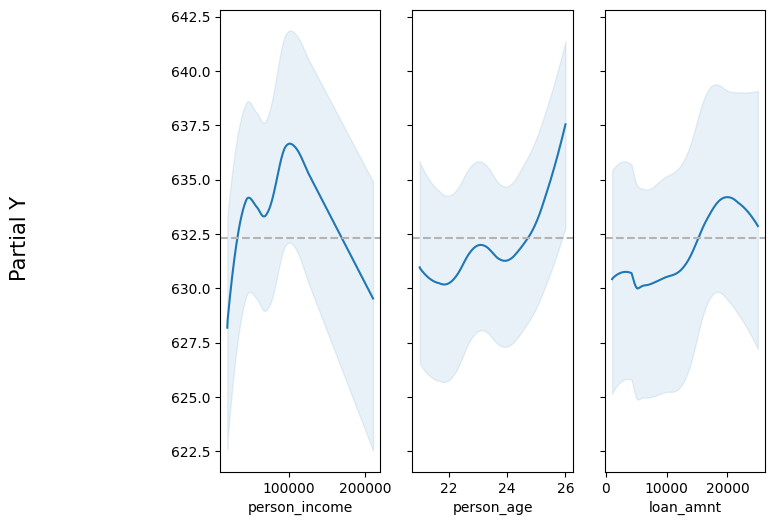

In [18]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize=(12, 6))

array([<Axes: xlabel='person_income'>, <Axes: xlabel='person_age'>,
       <Axes: xlabel='loan_amnt'>], dtype=object)

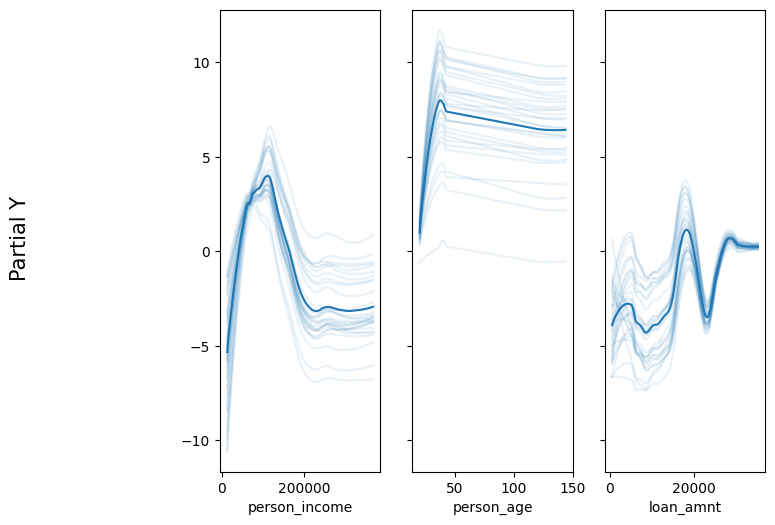

In [19]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize=(12, 6))

Looking at the PDP and ICE plots, we can learn a lot more about how each variable contributes to credit score prediction in this model.

Starting with person_income, the PDP shows a strong, clear effect: predicted credit score increases quickly as income rises, especially up to around $100,000. After that, the curve starts to flatten, which suggests that the benefit of income on credit score levels off at higher income levels. The ICE plot backs this up — most individual lines show a consistent upward trend. This tells us that across nearly all individuals, as income increases, their predicted credit score goes up. This result makes sense in real life too: income is often a sign of financial stability, which contributes to better credit management and, in turn, higher credit scores. This is also consistent with what I found in my previous project, where income was the most important factor when predicting loan amount. It seems that income plays a central role across different financial behaviors.

Now, looking at person_age, the PDP is a bit flatter and more subtle, but the ICE plot tells a more powerful story. All the individual lines trend upward, which means that as a person gets older, their predicted credit score consistently increases — even if the average effect looks smaller when viewed in the PDP. This makes sense: credit score tends to improve with age because older individuals often have longer credit histories, more established credit accounts, and fewer missed payments. In my previous project, however, age was the least important variable when predicting loan amount. So it's interesting to see it become more relevant here. This shift highlights how different prediction targets — credit score vs. loan amount — can bring out different relationships between the same set of variables.

Finally, loan_amnt shows the weakest effect in both plots. The PDP is basically flat, and the ICE lines barely move. This tells me that loan amount has very little influence on credit score in this model. That surprised me a bit, because in my previous project, loan amount played a slightly stronger role when predicting credit score. I expected there to be a more meaningful connection, since people who are eligible for larger loans often have higher credit scores. But here, the model seems to be learning that loan amount isn’t consistently useful for predicting credit score — at least not compared to income and age.